# Adapting covexivity analysis to Markov chains in more than one dimension

Let's see if we can reproduce the same results as in `investigate_concavity_convexity.ipynb` but with Markov chains with two-dimensional state spaces. Note the differences now:
  - The "distance" from the absorbing state is not well defined. We can define the distance in two-dimensions though.
  - There is more than one boundary (not just (B, B), but also all (i, B) and (B, j))

We will first consider a 2D random walk.

In [1]:
import trunc
import numpy as np

In [2]:
def make_2d_random_walk_state_space(bound):
    """
    Makes the state space a 2D absorbing random walk:
    (0, 0) is the origin, the absorbing state
    (x, y) is the state being x steps away from the origin horizontally, y steps away from the origin vertically
    x and y borth bounded by `bound'
    """
    return [(x, y) for x in range(bound) for y in range(bound)]

In [3]:
def make_2d_random_walk_matrix(p_h_away, p_h_toward, p_v_away, p_v_toward, bound, state_space):
    """
    Makes the transition matrix for a 2D absorbing random walk:
      - Take a step away horizontally from the origin with probability `prob_step_away_horizontal`
      - Take a step closer horizintally to the origin with probability 1 - `prob_step_away_horizontal`
      - Take a step away vertically from the origin with probability `prob_step_away_vertical`
      - Take a step closer vertically to the origin with probability 1 - `prob_step_away_vertical`
      - Stop once you return to the origin.
    """
    transition_matrix = np.zeros((bound**2, bound**2))
    for i1, s1 in enumerate(state_space[1:]):
        for i2, s2 in enumerate(state_space):
            delta = (s2[0] - s1[0], s2[1] - s1[1])
            if delta == (1, 0):
                transition_matrix[i1+1, i2] = p_h_away
            if delta == (-1, 0):
                transition_matrix[i1+1, i2] = p_h_toward
            if delta == (0, 1):
                transition_matrix[i1+1, i2] = p_v_away
            if delta == (0, -1):
                transition_matrix[i1+1, i2] = p_v_toward
    diag = np.ones(bound**2) - transition_matrix.sum(axis=1)
    transition_matrix += np.identity(bound**2) * diag
    return transition_matrix

Now consider $h_{s, (B, B)}$ the probability of hitting the state $(B, B)$. This is the 'furthest' state away from the absorbing state.

(3D plots will be used to investigate the concavity / convexity, as they are quick and easy to look at. But they shouldn't be used in proper analysis as they are ambiguous. If they shows something, I will develop a one-number 'measure' rather than a 3D plot)

In [4]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from mpl_toolkits import mplot3d

In [5]:
def plot_convexity_2d_random_walk(p_h_away, p_h_toward, p_v_away, p_v_toward, bound):
    state_space = make_2d_random_walk_state_space(bound)
    transition_matrix = make_2d_random_walk_matrix(p_h_away, p_h_toward, p_v_away, p_v_toward, bound, state_space)
    probs = trunc.find_hitting_probs(transition_matrix, state_space, (bound-1, bound-1))
    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes(projection='3d')
    xs = range(bound)
    ys = range(1, bound)
    X, Y = np.meshgrid(xs, ys)
    Z = np.array([[probs[(x, y)] for x in xs] for y in ys])
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel("Horizontal distance from (0, 0)")
    ax.set_ylabel("Vertical distance from (0, 0)")
    ax.set_zlabel("Probabiltiy of hitting (B, B)")
    return fig

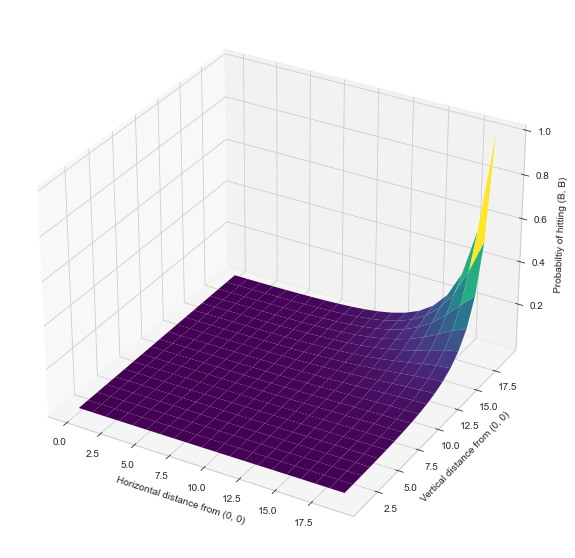

In [6]:
# When the random walk does not shoot off to infinity: p_h_away < p_h_toward, p_v_away < p_v_toward
plot_convexity_2d_random_walk(
    p_h_away=0.45,
    p_h_toward=0.55,
    p_v_away=0.45,
    p_v_toward=0.55,
    bound=20
);

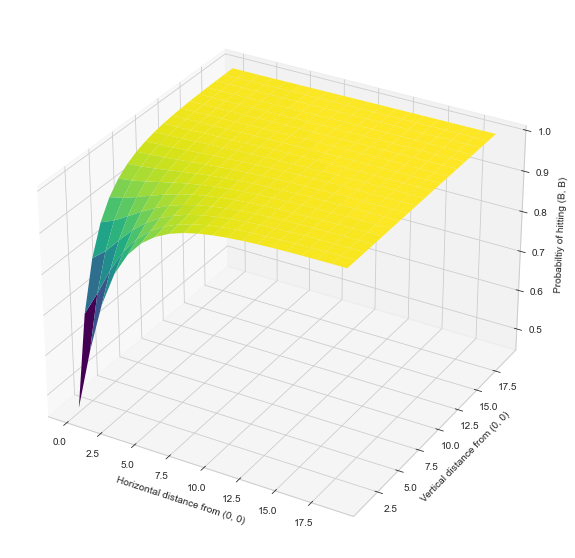

In [7]:
# When the random walk does shoot off to infinity: p_h_away > p_h_toward, p_v_away > p_v_toward
plot_convexity_2d_random_walk(
    p_h_away=0.55,
    p_h_toward=0.45,
    p_v_away=0.55,
    p_v_toward=0.45,
    bound=20
);

It seems that the convexity / concavity still holds for a 2D state space. However, there are a number of ways of 'shooting off' to infinity now:

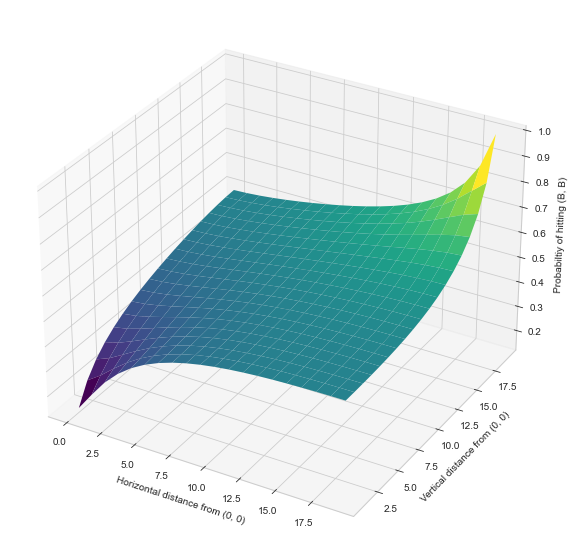

In [8]:
# When the random walk does shoot off to infinity but only in one directon:
# p_h_away > p_h_toward, p_v_away < p_v_toward
plot_convexity_2d_random_walk(
    p_h_away=0.55,
    p_h_toward=0.45,
    p_v_away=0.45,
    p_v_toward=0.55,
    bound=20
);

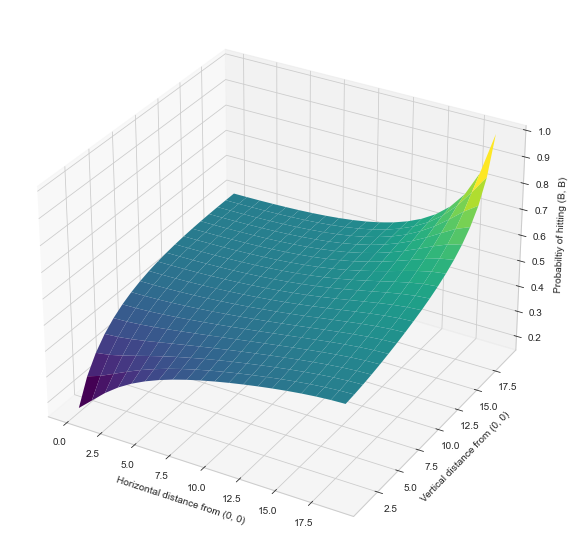

In [9]:
# When the random walk does shoot off to infinity but only in one directon:
# p_h_away < p_h_toward, p_v_away > p_v_toward
plot_convexity_2d_random_walk(
    p_h_away=0.45,
    p_h_toward=0.55,
    p_v_away=0.55,
    p_v_toward=0.45,
    bound=20
);

It's now not so clear cut. This is because the measure $h_{s, B}$ is the probabiltiy of hitting the furthermost boundary (B, B), rather than anywhere along the boundary. Let's instead consider $h_{s, \tilde{B}}$ the maximum probability of hitting any state on the boundary region.

A small edit to the `find_hitting_probs` function is needed, but this does not change the mathematics. In general $h_{s, A}$ is the probability of hitting _any_ state in a set of states $A$.

In [10]:
def find_hitting_probs(transition_matrix, state_space, boundary_region):
    """
    Finds the maximum probability of ever reaching a state in the boundary_region
    from every transient state not in the boundary_region.
    """
    P = transition_matrix.copy()
    n_states = len(state_space)
    Bi = [state_space.index(state) for state in boundary_region]
    absorbing_states = [si for si, s in enumerate(state_space) if P[si, si]==1.0]
    transient_states = [si for si, s in enumerate(state_space) if si not in absorbing_states]
    Bit = [transient_states.index(i) for i in Bi]
    n_transient = len(transient_states)
    for i in Bi:
        P[i] = np.zeros(n_states)
    A = P[:, transient_states][transient_states] - np.identity(n_transient)
    b = np.zeros(n_transient)
    for it in Bit:
        b[it] = -1
    p = np.linalg.solve(A, b)
    hitting_probabilities = {state_space[s]: p[si] for si, s in enumerate(transient_states)}
    return hitting_probabilities

In [11]:
def plot_convexity_2d_random_walk_modified(p_h_away, p_h_toward, p_v_away, p_v_toward, bound):
    state_space = make_2d_random_walk_state_space(bound)
    transition_matrix = make_2d_random_walk_matrix(p_h_away, p_h_toward, p_v_away, p_v_toward, bound, state_space)
    boundary_region = [(i, bound-1) for i in range(bound-1)] + [(bound-1, j) for j in range(bound-1)] + [(bound-1, bound-1)]
    probs = find_hitting_probs(transition_matrix, state_space, boundary_region)
    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes(projection='3d')
    xs = range(bound)
    ys = range(1, bound)
    X, Y = np.meshgrid(xs, ys)
    Z = np.array([[probs[(x, y)] for x in xs] for y in ys])
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel("Horizontal distance from (0, 0)")
    ax.set_ylabel("Vertical distance from (0, 0)")
    ax.set_zlabel("Probabiltiy of hitting Boundary region")
    return fig

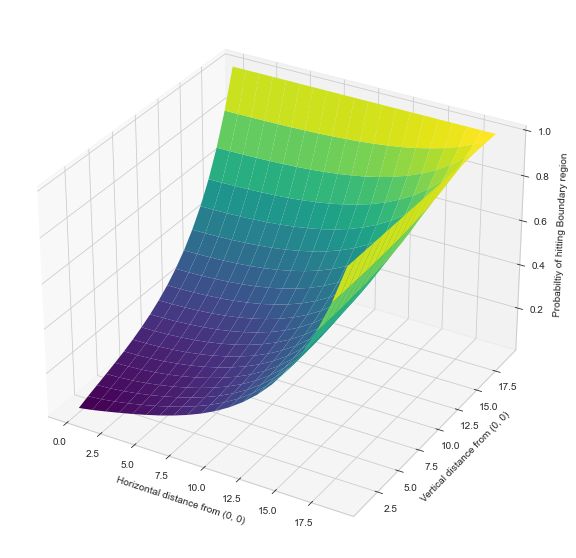

In [12]:
# When the random walk does not shoot off to infinity: p_h_away < p_h_toward, p_v_away < p_v_toward
plot_convexity_2d_random_walk_modified(
    p_h_away=0.45,
    p_h_toward=0.55,
    p_v_away=0.45,
    p_v_toward=0.55,
    bound=20
);

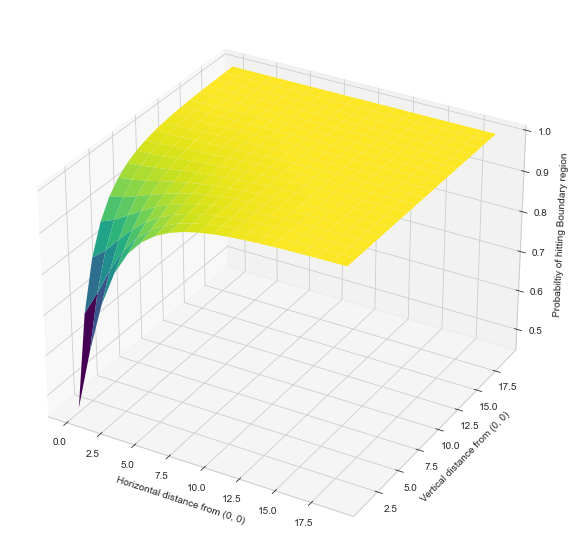

In [13]:
# When the random walk does shoot off to infinity: p_h_away > p_h_toward, p_v_away > p_v_toward
plot_convexity_2d_random_walk_modified(
    p_h_away=0.55,
    p_h_toward=0.45,
    p_v_away=0.55,
    p_v_toward=0.45,
    bound=20
);

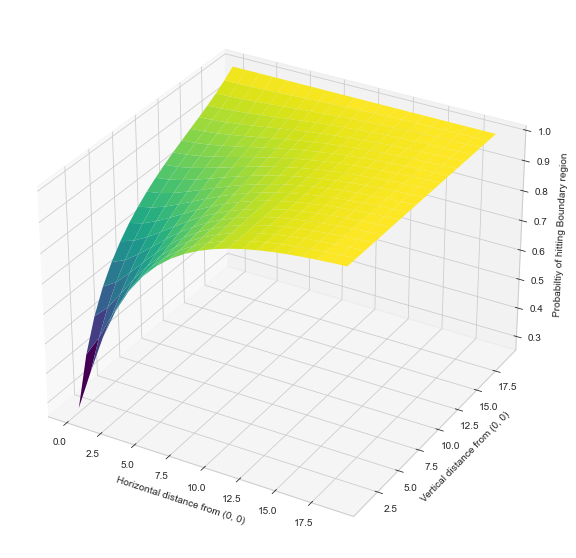

In [14]:
# When the random walk does shoot off to infinity but only in one directon:
# p_h_away > p_h_toward, p_v_away < p_v_toward
plot_convexity_2d_random_walk_modified(
    p_h_away=0.55,
    p_h_toward=0.45,
    p_v_away=0.45,
    p_v_toward=0.55,
    bound=20
);

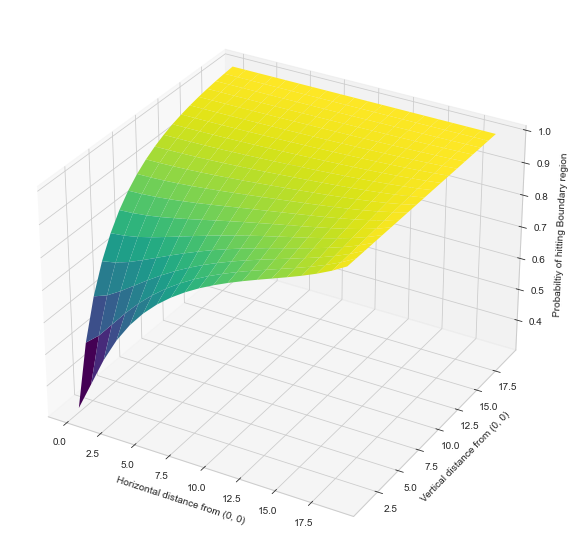

In [15]:
# When the random walk does shoot off to infinity but only in one directon:
# p_h_away < p_h_toward, p_v_away > p_v_toward
plot_convexity_2d_random_walk_modified(
    p_h_away=0.45,
    p_h_toward=0.55,
    p_v_away=0.55,
    p_v_toward=0.45,
    bound=20
);

So this is much better.

However, these surfaces are not strictly _concave_.
Consider the line going from (0, B) to (B, 0):

In [16]:
bound = 20
state_space = make_2d_random_walk_state_space(bound)
transition_matrix = make_2d_random_walk_matrix(
    p_h_away=0.45,
    p_h_toward=0.55,
    p_v_away=0.55,
    p_v_toward=0.45,
    bound=bound,
    state_space=state_space
)
boundary_region = [(i, bound-1) for i in range(bound-1)] + [(bound-1, j) for j in range(bound-1)] + [(bound-1, bound-1)]
probs = find_hitting_probs(transition_matrix, state_space, boundary_region)

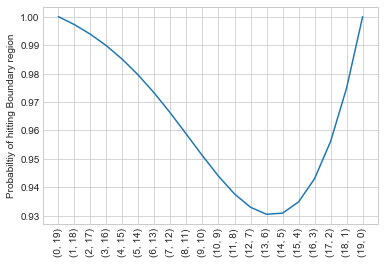

In [17]:
fig, ax = plt.subplots(1)
line = [(i, bound - i - 1) for i in range(bound)]
ax.plot([probs[s] for s in line])
ax.set_ylabel('Probabiltiy of hitting Boundary region')
ax.set_xticks(range(bound))
ax.set_xticklabels(line, rotation=90)
plt.show()

This is neither convex nor concave.

However, the line (0, 0) to (B, B) _is_ concave. So maybe it's something to do with distance from the absorbing state:

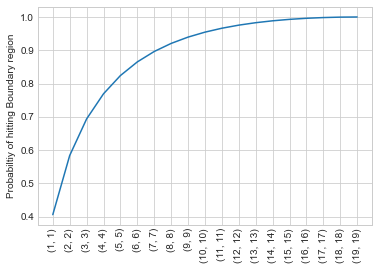

In [18]:
fig, ax = plt.subplots(1)
line = [(i, i) for i in range(1, bound)]
ax.plot([probs[s] for s in line])
ax.set_ylabel('Probabiltiy of hitting Boundary region')
ax.set_xticks(range(bound-1))
ax.set_xticklabels(line, rotation=90)
plt.show()

What if we just looked at convexity / concavity _in the X and Y directions_:

In [19]:
import matplotlib as mpl
def plot_directional_convexity_2d_random_walk(p_h_away, p_h_toward, p_v_away, p_v_toward, bound):
    state_space = make_2d_random_walk_state_space(bound)
    transition_matrix = make_2d_random_walk_matrix(p_h_away, p_h_toward, p_v_away, p_v_toward, bound, state_space)
    boundary_region = [(i, bound-1) for i in range(bound-1)] + [(bound-1, j) for j in range(bound-1)] + [(bound-1, bound-1)]
    probs = find_hitting_probs(transition_matrix, state_space, boundary_region)

    fig, axarr = plt.subplots(1, 2, figsize=(15, 5))
    colors = plt.cm.viridis(np.linspace(0, 1, bound))
    mappable = plt.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=0, vmax=bound),
        cmap=plt.cm.viridis)
    for x in range(bound):
        ys = range(1, bound)
        ps = [probs[(x, y)] for y in ys]
        axarr[0].plot(ps, c=colors[x])
    axarr[0].set_xlabel('Vertical distance', fontsize=14)
    axarr[0].set_ylabel("Probability of reaching the Boundary Region", fontsize=12)
    cbar = fig.colorbar(mappable, ax=axarr[0])
    cbar.set_label("Horizontal distance", fontsize=14)
    for y in range(bound):
        xs = range(1, bound)
        ps = [probs[(x, y)] for x in xs]
        axarr[1].plot(ps, c=colors[y])
    axarr[1].set_xlabel('Horizontal distance', fontsize=14)
    axarr[1].set_ylabel("Probability of reaching the Boundary Region", fontsize=12)
    cbar = fig.colorbar(mappable, ax=axarr[1])
    cbar.set_label("Vertical distance", fontsize=14)
    return fig

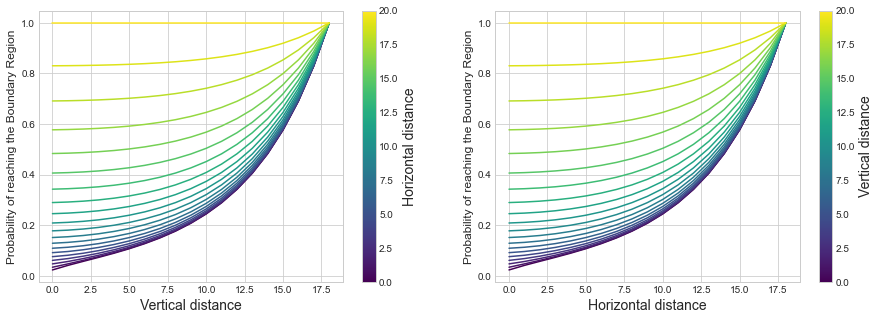

In [20]:
# When the random walk does not shoot off to infinity: p_h_away < p_h_toward, p_v_away < p_v_toward
plot_directional_convexity_2d_random_walk(
    p_h_away=0.45,
    p_h_toward=0.55,
    p_v_away=0.45,
    p_v_toward=0.55,
    bound=20
);

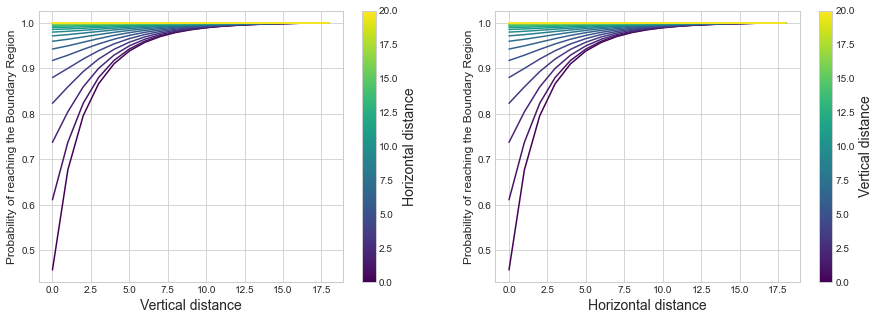

In [21]:
# When the random walk does shoot off to infinity: p_h_away > p_h_toward, p_v_away > p_v_toward
plot_directional_convexity_2d_random_walk(
    p_h_away=0.55,
    p_h_toward=0.45,
    p_v_away=0.55,
    p_v_toward=0.45,
    bound=20
);

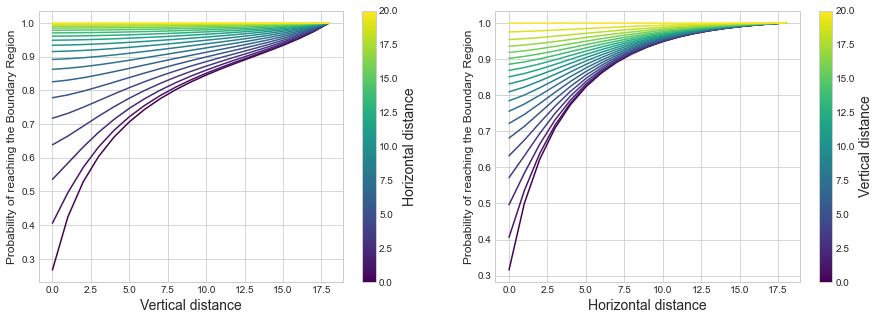

In [22]:
# When the random walk does shoot off to infinity but only in one directon:
# p_h_away > p_h_toward, p_v_away < p_v_toward
plot_directional_convexity_2d_random_walk(
    p_h_away=0.55,
    p_h_toward=0.45,
    p_v_away=0.45,
    p_v_toward=0.55,
    bound=20
);

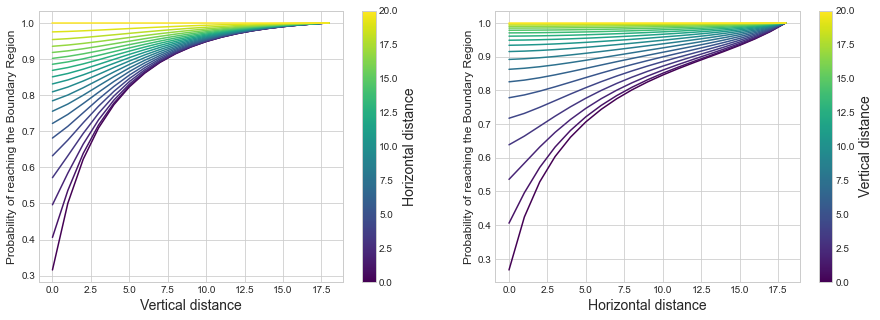

In [23]:
# When the random walk does shoot off to infinity but only in one directon:
# p_h_away < p_h_toward, p_v_away > p_v_toward
plot_directional_convexity_2d_random_walk(
    p_h_away=0.45,
    p_h_toward=0.55,
    p_v_away=0.55,
    p_v_toward=0.45,
    bound=20
);